<a href="https://colab.research.google.com/github/kcw0331/Deeplearning/blob/main/6_2_understanding_recurrent_neural_networks(%EA%B9%80%EC%B0%BD%EC%9A%B0)2021%EB%85%844%EC%9B%9428%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [ ]:
from tensorflow.keras.layers import SimpleRNN   

- RNN에서는 SimpleRNN을 사용해서 RNN을 사용할 수 있다. 

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

- 모델은 Sequential을 이용해서 사용을 해준다. 
- 그리고 지난주에 배웠던 Embedding layer를 붙일 것이다. 
- 그래서 Embedding layer와 SimpleRNN하면 아래와 같이 만들어 진다.

In [ ]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))  #여기에서는 RNN 블럭이 32개 있다는 것이다. 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))  #return_sequences=True이걸 해주게 되면 sequences길이 만큼 return을 해준다. 예를 들어 I am tom이라고하면 3개의 sequneces를 가지게 된다. 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

- RNN구조를 여러 층으로 쌓고 싶으면, return_sequences르 여러개 만들어 주면된다.

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


- 만약에 IMDB에서 movie가 positive인지 negative인지를 판단해줄려면 마지막에 return_sequences=True을 안해주고 model.add(SimpleRNN(32))이것을 해주게 되면 마지막 output을 통해서 movie가 positive인지 negative인지를 판단할 수 있게된다. 

- 근데 우리가 사용하는게 여러가지 결과들을 받아 와서 사용하는 경우에는 마지막에 model.add(SimpleRNN(32, return_sequences=True)를 써줘서 해야 하는 경우도 있다고 교수님이 말씀하심.

Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

- 우리가 보게 될 데이터는 IMDB의 movie데이터 이다. 

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features 빈도수가 많은 단어를 사용해준다. 
maxlen = 500  # cut texts after this number of words (among top max_features most common words) 그리고 여기에서 앞에서 500단어까지만 보겠다는 것이다. 
batch_size = 32 #그리고 batch_size는 32가 된다. 

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


- pad_sequences ; 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용한다. 2021년 5월 3일 복습할때 적음.

Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

- 여기에서는 tensor flow 모형을 만든다. 

In [ ]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))  #Embedding을 해줘서 10000개를 32차원으로 해준다. 
model.add(SimpleRNN(32))  #그 Embedding된 32차원의 feature를 SimpleRNN구조로 해서 사용을 한다음에 
model.add(Dense(1, activation='sigmoid'))  #마지막 layer에서 dense layer로 빼가지고 결과를 보겠다는 것이다. 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 76s 476ms/step - loss: 0.6604 - acc: 0.5863 - val_loss: 0.4268 - val_acc: 0.8260
Epoch 2/10
157/157 [==============================] - 75s 476ms/step - loss: 0.3861 - acc: 0.8425 - val_loss: 0.3930 - val_acc: 0.8382
Epoch 3/10
157/157 [==============================] - 74s 472ms/step - loss: 0.2886 - acc: 0.8858 - val_loss: 0.3446 - val_acc: 0.8594
Epoch 4/10
157/157 [==============================] - 74s 470ms/step - loss: 0.2232 - acc: 0.9175 - val_loss: 0.4152 - val_acc: 0.8078
Epoch 5/10
157/157 [==============================] - 75s 479ms/step - loss: 0.1719 - acc: 0.9398 - val_loss: 0.3638 - val_acc: 0.8578
Epoch 6/10
157/157 [==============================] - 76s 481ms/step - loss: 0.1127 - acc: 0.9616 - val_loss: 0.4000 - val_acc: 0.8462
Epoch 7/10
157/157 [==============================] - 75s 477ms/step - loss: 0.0761 - acc: 0.9763 - val_loss: 0.4334 - val_acc: 0.8592
Epoch 8/10
157/157 [==============================] - 7

Let's display the training and validation loss and accuracy:

- 위를 통해 나온 결과를 아래 코드를 통해 그림으로 그려본다.

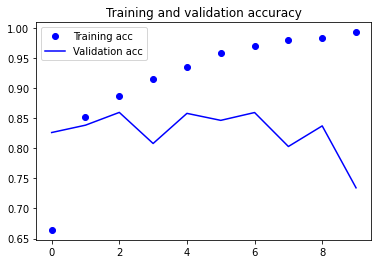

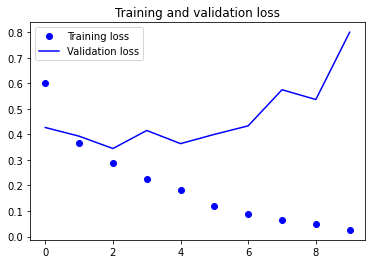

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- chapter 3에서는 88%의 test accuracy가 나왔는데, small recurrent network에서는 85%의 validation accuracy가 나와서 좋은 결과를 가지지 못했다고 나오게 된다. 

- 여기에서는 SimpelRNN이여서 좋은 결과를 가지지 못했지만 아래에서 나오는 LSTM이던지 추가적으로 GRU를 통해 좋은 결과를 가진다는 것을 볼 수 있을 것이다.

- 그래서 RNN구조가 Simple했다는 문제점도 말해주고 있다. 

- 여기까지 설명을 하고 강의 노트 p11로 가서 강의노트를 설명하심.

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [ ]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))  #기존에 SimpleRNN이 있던 부분을 LSTM으로 바꾸어 주었다. 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 43s 95ms/step - loss: 0.6055 - acc: 0.6644 - val_loss: 0.3373 - val_acc: 0.8674
Epoch 2/10
157/157 [==============================] - 14s 91ms/step - loss: 0.3160 - acc: 0.8782 - val_loss: 0.2877 - val_acc: 0.8850
Epoch 3/10
157/157 [==============================] - 14s 91ms/step - loss: 0.2368 - acc: 0.9133 - val_loss: 0.2867 - val_acc: 0.8816
Epoch 4/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1957 - acc: 0.9279 - val_loss: 0.5390 - val_acc: 0.8122
Epoch 5/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1808 - acc: 0.9364 - val_loss: 0.3180 - val_acc: 0.8746
Epoch 6/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1504 - acc: 0.9471 - val_loss: 0.3038 - val_acc: 0.8726
Epoch 7/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1414 - acc: 0.9510 - val_loss: 0.3687 - val_acc: 0.8778
Epoch 8/10
157/157 [==============================] - 14s 91ms

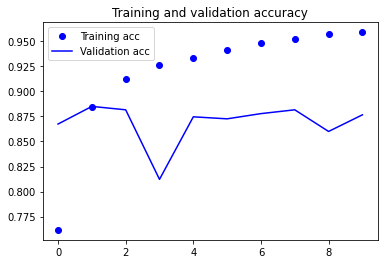

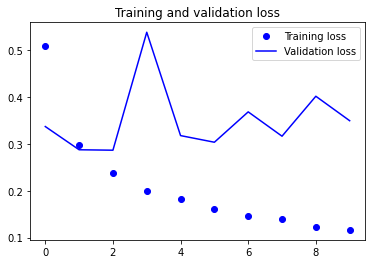

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- Training and validation accuracy에서는 Training accuracy는 1에 가깝게 되는데, validation accuracy는 4부분에서 0.87정도 나오기 때문에 4에서 멈추는 것이 좋다고 판단이 된다. 그래서 epoch을 2에서 3정도에서 멈춰 주는것이 좋겠다. 

- 여기까지 강의노트 p14부분이고 강의노트로 넘어가서 p15부터 강의노트에 대해 설명을 하심.